In [1]:
from datetime import datetime
from collections import defaultdict
import re
import pickle
import pandas as pd
from netCDF4 import Dataset, num2date #pylint: disable=no-name-in-module
import numpy as np
import numpy.ma as ma

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.optimize as opt
from scipy.stats import linregress
import seaborn as sn
import cmasher as cmr
import mpl_axes_aligner

import os
import sys
from pathlib import Path
path = Path(os.getcwd())
path_parent=str(path.parent.absolute())
path_module=path_parent+'/src/SuPerSim'
sys.path.insert(0, os.path.abspath(path_module))

from SuPerSim import get_all_stats, load_all_pickles, plot_all

In [2]:
################################################
# Here, write the paths to your own data files #
################################################

# this is just introduced for convenience
path_data = path_parent+'/examples/data/'

# those are the real variables
path_forcing_merra2 = path_data+'/scaled_merra2_Aksaut.nc'
path_ground = path_data+'North/result_soil_temperature.nc'
path_snow = path_data+'North/result_snow_depth.nc'
path_swe = path_data+'North/result_swe.nc'
path_thaw_depth = path_data+'North/result_thaw_depth.nc'
path_repository = path_data+'North/folder_manifest.csv'
path_pickle = path_parent+'/examples/python_pickles/'

path_horizon = path_data+'/horizon.csv'

###############################################################
# Enter the parameters of your site and of the rockfall event #
###############################################################

site = 'Aksaut_North'
year_bkg_end = 2010
year_trans_end = 2023
forcing_list = ['merra2']
path_forcing_list = [path_forcing_merra2]
date_event = [2021, 12, 31]
topo_event = []
no_weight = True
consecutive = 7
glacier = False
min_glacier_depth = 100

Succesfully opened the pre-existing pickle: df_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: reanalysis_stats_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: list_valid_sim_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: melt_out_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: df_stats_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: rockfall_values_Aksaut_North.pkl

---------------------------------------------------------------------------------------------

Fisheye view of the sky with the visible portion in blue and the blocked one in black:


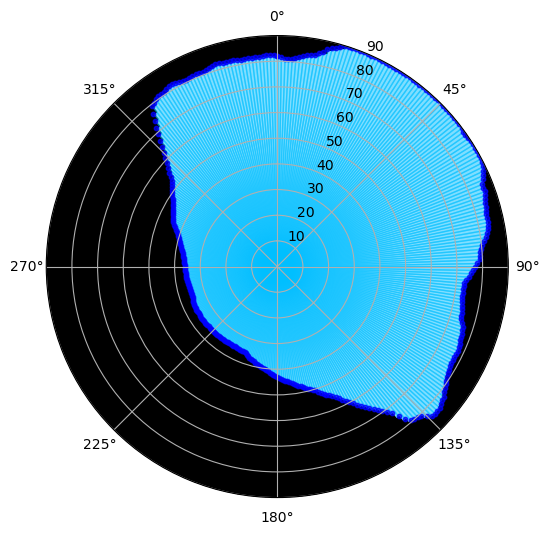


---------------------------------------------------------------------------------------------

The following plot is a histogram of the distribution of the statistical weights of all simulations:


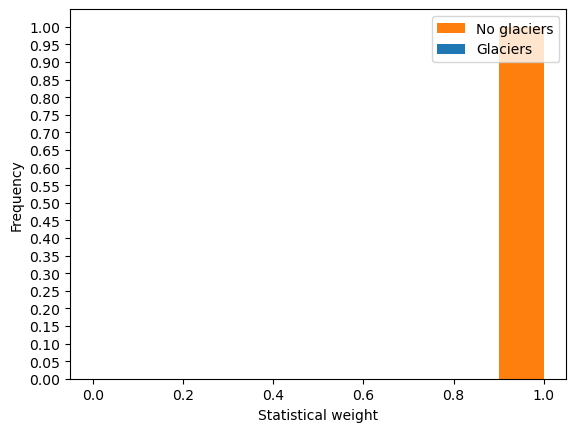


---------------------------------------------------------------------------------------------

The following plot is a histogram of the distribution of glacier simulations wrt to altitude, aspect, slope, and forcing:


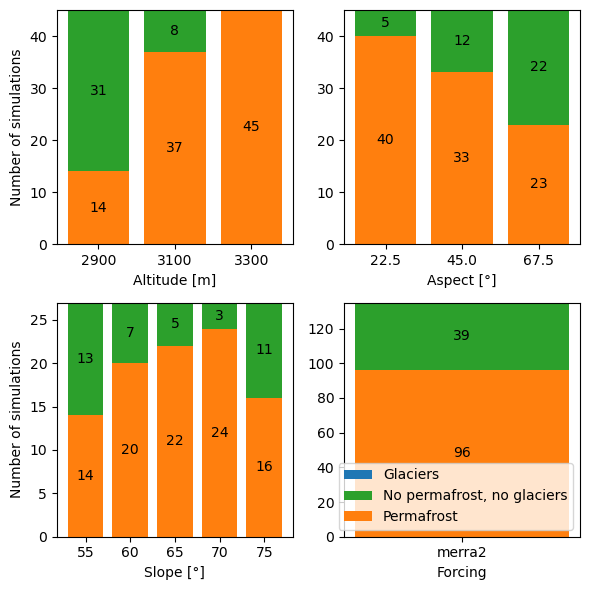


---------------------------------------------------------------------------------------------

Plots of the normalized distance of air and ground temperature, water production, and thaw_depth as a function of time

---------------------------------------------------------------------------------------------

Granularity: week and month side by side


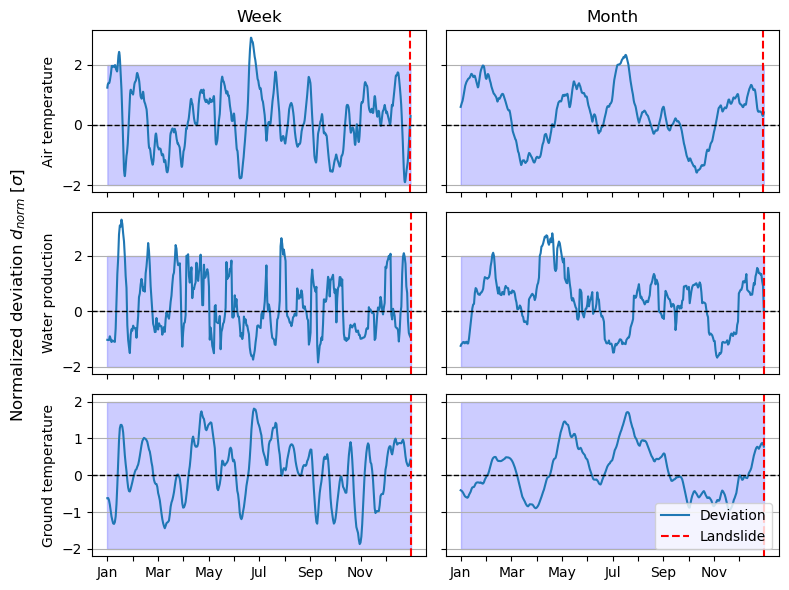


---------------------------------------------------------------------------------------------

Granularity: year, plotted for all years


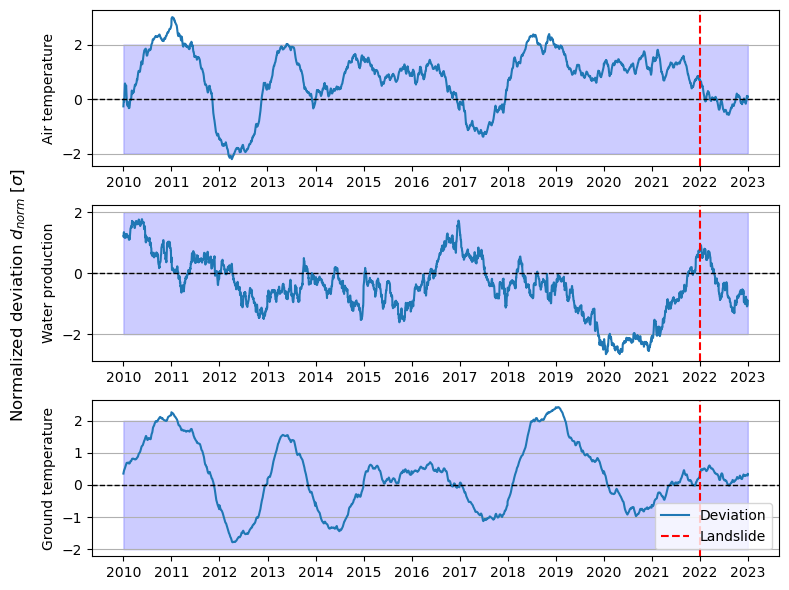


---------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------

Plot of yearly statistics for atmospheric timeseries. Mean and several quantiles for each year:


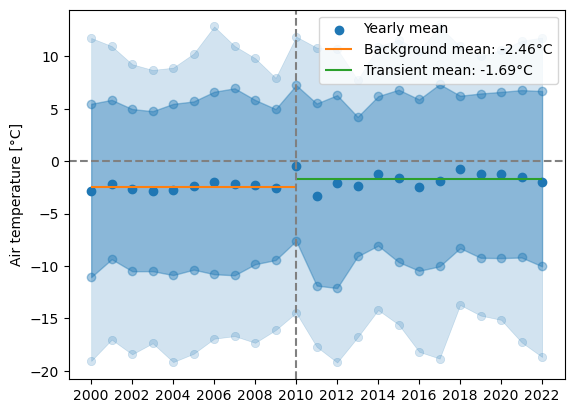

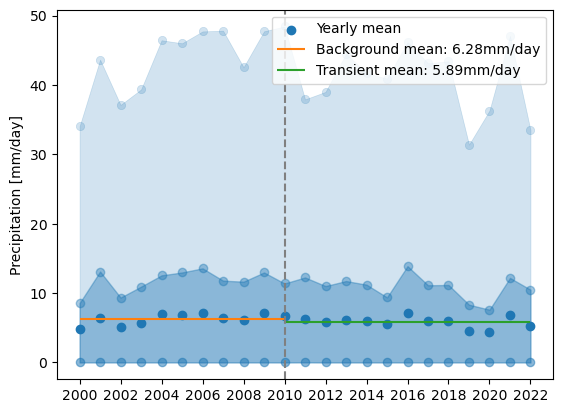


---------------------------------------------------------------------------------------------

Plot of yearly statistics for simulated timeseries. Mean and several quantiles for each year:


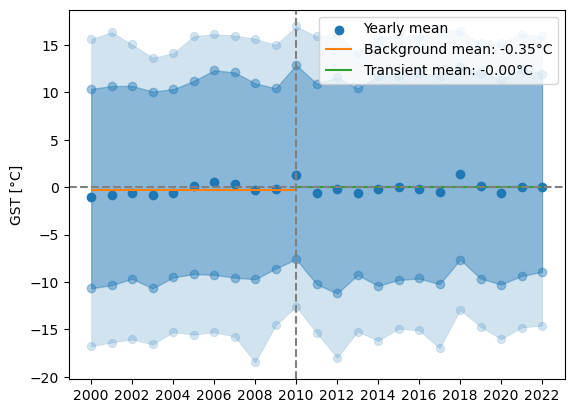

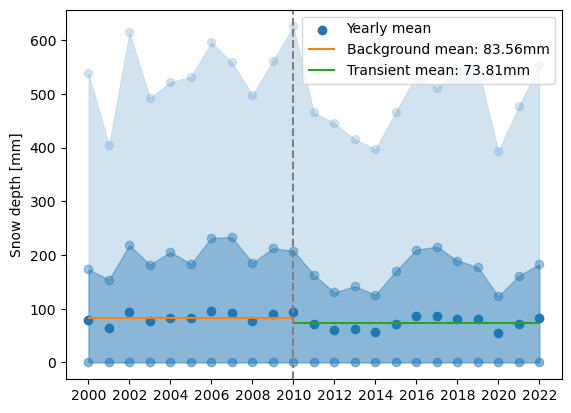

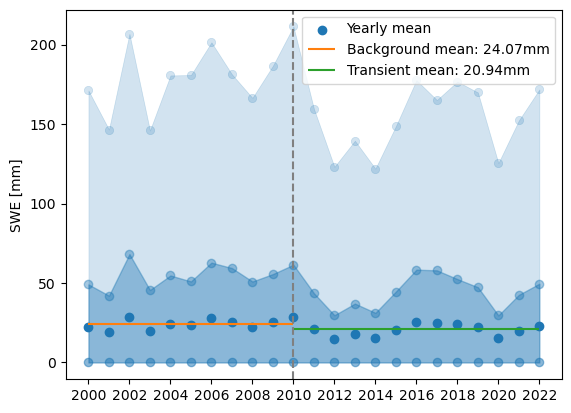

In [3]:
###############
# Ready to go #
###############

# When used for the first time, it createss the pickles
# When the pickles already exist, it simply loads them
# but it's easier to use the function 'load_all_pickles' for that
pkl = get_all_stats(
    forcing_list, path_forcing_list, path_repository, path_ground, path_snow, path_pickle,
    year_bkg_end, year_trans_end, consecutive,
    site, date_event, topo_event,
    glacier, min_glacier_depth)
reanalysis_stats = pkl['reanalysis_stats']
list_valid_sim = pkl['list_valid_sim']
dict_melt_out = pkl['dict_melt_out']
stats_melt_out_dic = pkl['stats_melt_out_dic']
df_stats = pkl['df_stats']
rockfall_values = pkl['rockfall_values']

# this is a function that allows the used to load the pickles in a much simpler way
pkl = load_all_pickles(site, path_pickle)
df = pkl['df']
reanalysis_stats = pkl['reanalysis_stats']
list_valid_sim = pkl['list_valid_sim']
dict_melt_out = pkl['dict_melt_out']
stats_melt_out_dic = pkl['stats_melt_out_dic']
df_stats = pkl['df_stats']
rockfall_values = pkl['rockfall_values']

# Finally, we can produce all the summary plots
plot_all(site, forcing_list, path_forcing_list, path_ground, path_snow, path_swe, path_thaw_depth, path_pickle,
         year_bkg_end, year_trans_end,
         path_horizon=path_horizon, no_weight=True, show_glaciers=True,
         individual_heatmap=False, polar_plots=False, parity_plot=True)

In [4]:
from SuPerSim.runningstats import mean_all_altitudes, mean_all_reanalyses
from SuPerSim.open import open_air_nc, open_ground_nc
from SuPerSim.constants import colorcycle, units


#####################################################################################
# OPEN THE VARIOUS FILES
#####################################################################################

pkl = load_all_pickles(site, path_pickle)
df = pkl['df']
list_valid_sim = pkl['list_valid_sim']
df_stats = pkl['df_stats']
rockfall_values = pkl['rockfall_values']

#####################################################################################
# PLOTS
#####################################################################################

list_vars = ['time_air', 'temp_air', 'SW_flux', 'SW_direct_flux', 'SW_diffuse_flux', 'precipitation']
list_series = [open_air_nc(i) for i in path_forcing_list]
list_series_b = [[list_series[j][i] for j in range(len(list_series))] for i in range(len(list_series[0]))]
air_all_dict = dict(zip(list_vars, list_series_b))

time_air_all = air_all_dict['time_air']
temp_air_all = air_all_dict['temp_air']
precipitation_all = air_all_dict['precipitation']

mean_air_temp = mean_all_reanalyses(time_air_all,
                                    [mean_all_altitudes(i, site, path_pickle, no_weight) for i in temp_air_all],
                                    year_bkg_end, year_trans_end)

_, time_ground, temp_ground = open_ground_nc(path_ground)

In [5]:
from SuPerSim.yearlystats import *

def plot_yearly_quantiles_side_by_side(list_yearly_quantiles, list_yearly_mean, list_site, year_bkg_end, year_trans_end):
    """ Function plots yearly statistics for 'air' timeseries, averaged over all reanalyses and altitudes
    
    Parameters
    ----------
    yearly_quantiles : pandas.core.frame.DataFrame
        Panda dataframe of the timeseries [0.023, 0.16, 0.5, 0.84, 0.977] quantiles per year.
        The lenght of the table is #quantiles x #years
        Multi-index : (quantile, year) and column: label_plot from function atmospheric_data_to_panda()
    yearly_mean : pandas.core.series.Series
        Panda dataframe of the mean of the timeseries for each year
        index : year and column: label_plot from function atmospheric_data_to_panda()
    list_site : list
        List of labels for the site of each entry
    year_bkg_end : int, optional
        Background period is BEFORE the start of the year corresponding to the variable, i.e. all time stamps before Jan 1st year_bkg_end
    year_trans_end : int, optional
        Same for transient period
    
    Returns
    -------
    fig : Figure
        Plot of yearly statistics for atmospheric timeseries. Mean and several quantiles for each year.
    """

    list_quantiles = sorted(np.unique([q for q,_ in list_yearly_quantiles[0].index]))
    list_years = sorted(np.unique([y for _,y in list_yearly_quantiles[0].index]))
    
    label_plot = [i.columns[0] for i in list_yearly_quantiles]

    mean_bkg = [np.mean(i.loc[list_years[0]:year_bkg_end-1]) for i in list_yearly_mean]
    mean_trans = [np.mean(i.loc[year_bkg_end:year_trans_end-1]) for i in list_yearly_mean]
    # mean_list = [mean_bkg, mean_trans]

    # exponent = [int(np.floor(np.log10(np.abs(i)))) for i in mean_list]
    # formatted_mean = [f"{m:.2e}" for i, m in enumerate(mean_list) if ((exponent[i] < -1) | (exponent[i]>2)) else float(f"{m:.2f}")]
    formatted_mean = [[f"{i:.2f}" for i in [mean_bkg[j], mean_trans[j]]] for j in range(2)]

    dict_points = {0: {'alpha': 0.2, 'width': 0.5},
                1: {'alpha': 0.4, 'width': 1.0},
                2: {'alpha': 1.0, 'width': 2.0},
                3: {'alpha': 0.4, 'width': 1.0},
                4: {'alpha': 0.2, 'width': 0.5}}

    fig, a = plt.subplots(1, 2, figsize=(8, 4), sharey='row')
    for idx,ax in enumerate(a):
        ax.scatter(list_years, list_yearly_mean[idx], color=colorcycle[idx], linestyle='None', label='Yearly mean')
        # ax.plot(xdata, mean_end, color=colorcycle[idx], label='Mean')
        # plt.plot(xdata, quantiles.iloc[dict_indices_quantiles[list_quantiles[2]]]['timeseries'], color=colorcycle[0])
        for i in [0,1,3,4]:
            ax.scatter(list_years, list_yearly_quantiles[idx].loc[[list_quantiles[i]]][label_plot[idx]], color=colorcycle[idx], alpha=dict_points[i]['alpha'], linewidth=dict_points[i]['width'])
        ax.fill_between(list_years, list_yearly_quantiles[idx].loc[[list_quantiles[1]]][label_plot[idx]], list_yearly_quantiles[idx].loc[[list_quantiles[3]]][label_plot[idx]],
                            alpha = 0.4, color=colorcycle[idx], linewidth=1,
                            # label='Quantiles 16-84'
                            )
        ax.fill_between(list_years, list_yearly_quantiles[idx].loc[[list_quantiles[0]]][label_plot[idx]], list_yearly_quantiles[idx].loc[[list_quantiles[4]]][label_plot[idx]],
                            alpha = 0.2, color=colorcycle[idx], linewidth=0.5,
                            # label='Quantiles 2.3-97.7'
                            )

        ax.hlines(mean_bkg[idx], list_years[0], year_bkg_end, color=colorcycle[2],
               label=f'Background mean: {formatted_mean[idx][0]}{units[label_plot[idx]]}')
        ax.hlines(mean_trans[idx],  year_bkg_end, list_years[-1], color=colorcycle[3],
               label=f'Transient mean: {formatted_mean[idx][1]}{units[label_plot[idx]]}')
            
        if label_plot[idx] in ['GST', 'Air temperature']:
            ax.axhline(y=0, color='grey', linestyle='dashed')

        ax.title.set_text(list_site[idx])
        
        if idx==0:
            ax.set_ylabel(label_plot[idx]+' ['+units[label_plot[idx]]+']')

        ax.legend(loc='upper right' if idx==0 else 'lower right')

    ylim = plt.gca().get_ylim()

    for ax in a:
        ax.vlines(year_bkg_end, ylim[0], ylim[1], color='grey', linestyle='dashed')

    plt.gca().set_ylim(ylim)

    plt.tight_layout()  # otherwise the right y-label is slightly clipped

    # Show the graph
    plt.show()
    plt.close()

    return fig


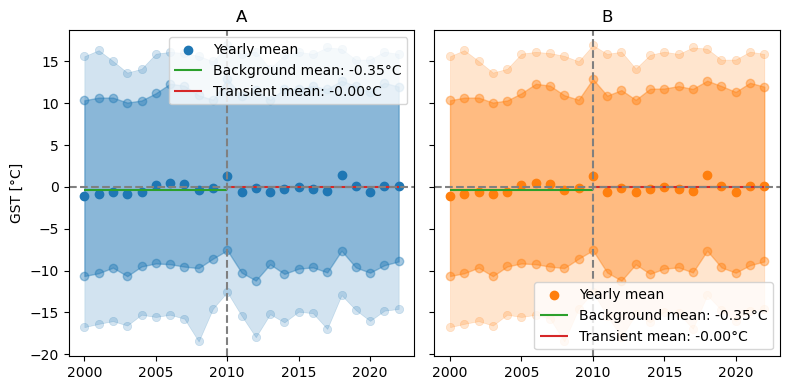

In [7]:
panda_test = sim_data_to_panda(time_ground, temp_ground, list_valid_sim, 'GST')
yearly_quantiles, yearly_mean = panda_data_to_yearly_stats(panda_test, year_trans_end)
fig = plot_yearly_quantiles_side_by_side([yearly_quantiles, yearly_quantiles], [yearly_mean, yearly_mean], ['A', 'B'], year_bkg_end, year_trans_end)